In [4]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") 
from sklearn.metrics import confusion_matrix
import numpy as np

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv('/content/drive/MyDrive/Soft_Com/Assignment_3/Dataset_2.csv',encoding='latin1')
df = df.sample(frac=1).reset_index(drop=True)
df.sample(10)

,text,polarity
5789,Shoutout to depression naps lol,1
5301,"@insanityreport hmmm...so, what industry in? ...",0
4796,Thank you to all of my new followers! I appre...,0
8106,can't believe how hot it is out there it's lu...,0
2331,@daverama Dave!?! Is that you!? http://twitte...,0
4899,"Obese children are more prone to depression, l...",1
10182,@DonnieWahlberg Wondering if he's still listen...,0
4331,@jpsale good luck! and dont forget the rings,0
6972,@thePISTOL http://twitpic.com/424qb - i must s...,0
7623,Sushi-time! cant go wrong with that,0


In [7]:
df.groupby('polarity').size()

polarity
0    8000
1    2314
dtype: int64

Text(0.5, 0, 'text')

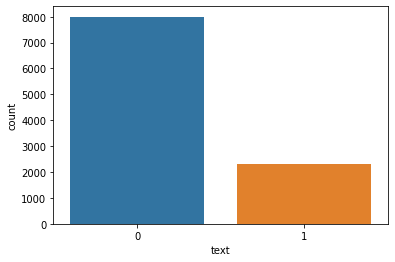

In [8]:

sns.countplot(df.polarity)
plt.xlabel('text')

In [9]:
class Sequences(Dataset):
    def __init__(self, data):
        self.vectorizer = CountVectorizer(stop_words='english')
        self.sequences = self.vectorizer.fit_transform(data.text.tolist())
        self.labels = data.polarity.tolist()
        self.token2idx = self.vectorizer.vocabulary_
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
    
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]

In [10]:
batch_size = 100

In [11]:
dataset = Sequences(df)
train_size = int(len(dataset)*.8);
test_size = int(len(dataset) - train_size);
train_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [12]:
len(dataset.token2idx)

22212

In [13]:
input_size = len(dataset.token2idx)
hidden_size = 64
num_classes = 2
num_layers = 4
learning_rate = 0.01
sequence_length = 1
num_epochs = 25

In [14]:
print(len(train_dataset))
print(len(test_dataset))

8251
2063


In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [16]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.D = 2
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, nonlinearity='relu',bidirectional=True)
        self.fc = nn.Linear(self.D*hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.D*self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # Forward propagate LSTM
        out, _ = self.rnn(x, h0) 
        h0 = torch.zeros(self.D*self.num_layers, out.size(0), self.hidden_size).to(device) 
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [17]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [19]:
# Train the model
y_pred = []
y_test = []
iter = []
losses = []
itr = 0
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (tweets, labels) in enumerate(train_loader):
        tweets = tweets.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        tweets = torch.tensor(tweets, dtype = torch.float)
        # Forward pass
        outputs = model(tweets)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        itr = itr + 1
        if (i+1) % 10 == 0:
            iter.append(itr)
            losses.append(loss.item())
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for tweets, labels in test_loader:
        tweets = tweets.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        tweets = torch.tensor(tweets, dtype = torch.float)
        outputs = model(tweets)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_pred.extend(predicted)
        y_test.extend(labels)

    print('Test Accuracy of the model : {} %'.format(100 * correct / total)) 

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/25], Step [10/83], Loss: 0.3561
Epoch [1/25], Step [20/83], Loss: 0.0707
Epoch [1/25], Step [30/83], Loss: 0.1222
Epoch [1/25], Step [40/83], Loss: 0.0474
Epoch [1/25], Step [50/83], Loss: 0.0626
Epoch [1/25], Step [60/83], Loss: 0.0118
Epoch [1/25], Step [70/83], Loss: 0.0164
Epoch [1/25], Step [80/83], Loss: 0.0108
Epoch [2/25], Step [10/83], Loss: 0.0001
Epoch [2/25], Step [20/83], Loss: 0.0001
Epoch [2/25], Step [30/83], Loss: 0.0302
Epoch [2/25], Step [40/83], Loss: 0.0023
Epoch [2/25], Step [50/83], Loss: 0.0007
Epoch [2/25], Step [60/83], Loss: 0.0000
Epoch [2/25], Step [70/83], Loss: 0.0000
Epoch [2/25], Step [80/83], Loss: 0.0000
Epoch [3/25], Step [10/83], Loss: 0.0010
Epoch [3/25], Step [20/83], Loss: 0.0002
Epoch [3/25], Step [30/83], Loss: 0.0024
Epoch [3/25], Step [40/83], Loss: 0.0002
Epoch [3/25], Step [50/83], Loss: 0.0013
Epoch [3/25], Step [60/83], Loss: 0.0001
Epoch [3/25], Step [70/83], Loss: 0.0000
Epoch [3/25], Step [80/83], Loss: 0.0000
Epoch [4/25], St

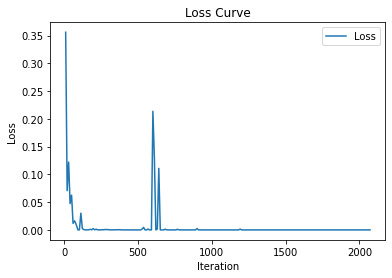

In [26]:
plt.plot(iter, losses, label='Loss')
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()

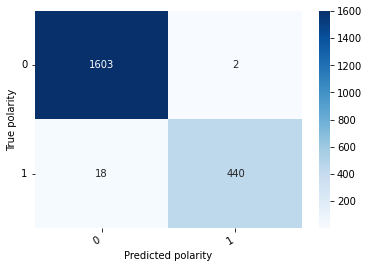

In [27]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True polarity')
  plt.xlabel('Predicted polarity');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=[0,1], columns=[0,1])
show_confusion_matrix(df_cm)


In [22]:
tp = 0
tn = 0
fp = 0
fn = 0
for i in range(len(y_test)):
  tn += ((y_pred[i] == 0) &  (y_test[i] == 0)).float()
  tp += ((y_pred[i] == 1) &  (y_test[i] == 1)).float()
  fn += ((y_pred[i] == 0) &  (y_test[i] == 1)).float()
  fp += ((y_pred[i] == 1) &  (y_test[i] == 0)).float()

print(tn, ' ', fn, ' ', fp, ' ', tp)

tensor(1603.)   tensor(18.)   tensor(2.)   tensor(440.)


In [23]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2* ((precision*recall)/(precision+recall))

In [24]:
print('Precision: ', precision.item(), 'Recall: ', recall.item(),  'F1_score: ', f1_score.item())

Precision:  0.9954751133918762 Recall:  0.960698664188385 F1_score:  0.9777777791023254


In [25]:
def table(l1, columns):
  plt.rcParams["figure.figsize"] = [10, 2]
  plt.rcParams["figure.autolayout"] = True
  
  fig, axs = plt.subplots(1, 1)
  data = np.column_stack(l1)
  axs.axis('tight')
  axs.axis('off')
  the_table = axs.table(cellText=data, colLabels=columns, loc='center', cellLoc = 'center')
  the_table.auto_set_font_size(False)
  the_table.set_fontsize(18)
  the_table.scale(1.5, 1.5)
  plt.show()